In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
%pip install --upgrade scanpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from GraphST import GraphST

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'

In [4]:
# the number of clusters
n_clusters = 7

In [5]:
dataset = '151673'

In [9]:
#input_dir = 'C:/Users/AGNISH/Desktop/IITK/VSCode/GraphST/151673/'
#adata = sc.read_10x_h5(input_dir +'filtered_feature_bc_matrix.h5')
#adata.var_names_make_unique()

# read data
file_fold = 'C:/Users/AGNISH/GraphST/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [28:16<00:00,  2.83s/it]


Optimization finished for ST data!


In [11]:
%pip install -i https://test.pypi.org/simple/ "scikit-misc==0.2.0rc1"

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/a5/f7/c8348e6fa8173c5298f125dc889b9c122f135f6d35c24643d3120d30882c/scikit_misc-0.2.0rc1-cp38-cp38-win_amd64.whl (9.9 MB)
  Attempting uninstall: scikit-misc
    Found existing installation: scikit-misc 0.1.4
    Uninstalling scikit-misc-0.1.4:
      Successfully uninstalled scikit-misc-0.1.4
Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install --upgrade numpy

                                              0.0/14.9 MB ? eta -:--:--
                                             0.0/14.9 MB 660.6 kB/s eta 0:00:23
                                              0.1/14.9 MB 1.4 MB/s eta 0:00:11
                                              0.3/14.9 MB 2.5 MB/s eta 0:00:06
     -                                        0.5/14.9 MB 3.0 MB/s eta 0:00:05
     -                                        0.7/14.9 MB 3.3 MB/s eta 0:00:05
     --                                       0.9/14.9 MB 3.5 MB/s eta 0:00:04
     ---                                      1.2/14.9 MB 3.8 MB/s eta 0:00:04
     ---                                      1.4/14.9 MB 3.9 MB/s eta 0:00:04
     ----                                     1.6/14.9 MB 4.0 MB/s eta 0:00:04
     -----                                    1.9/14.9 MB 4.1 MB/s eta 0:00:04
     -----                                    2.1/14.9 MB 4.2 MB/s eta 0:00:04
     ------                                   2.3/14.9 MB 

In [28]:
%pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [13]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [37]:
%Rinstall.packages("mclust")


UsageError: Line magic function `%Rinstall.packages("mclust")` not found.


In [14]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [15]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.4023335315097709


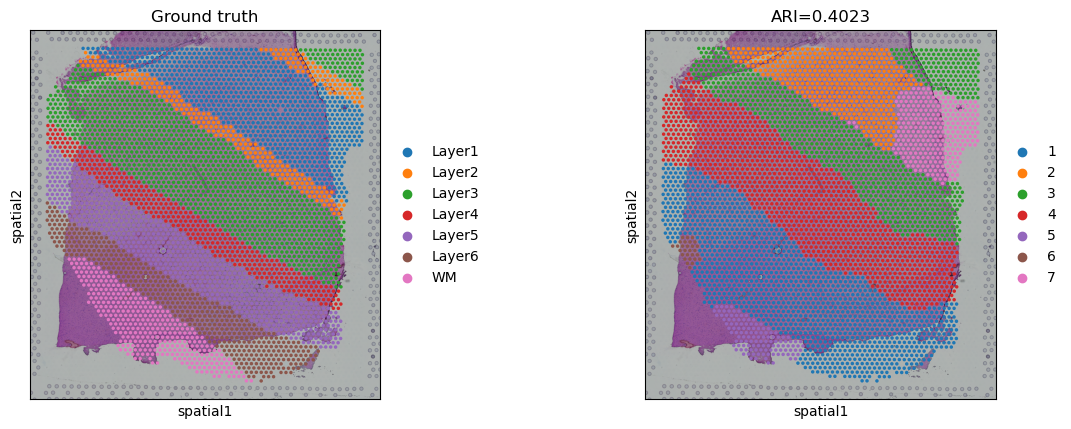

In [54]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

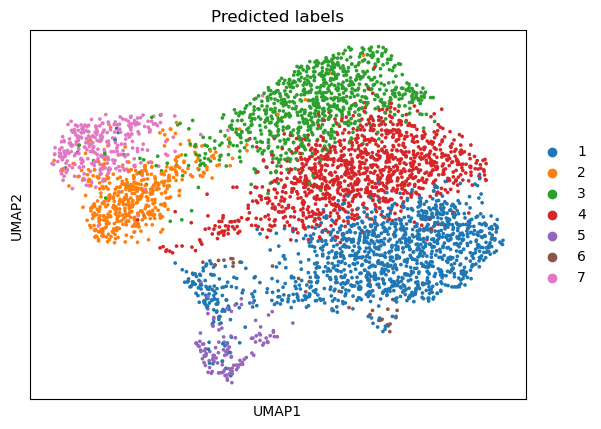

In [55]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)